<a href="https://colab.research.google.com/github/nurfnick/Data_Viz/blob/main/RecreatingMasters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recreating the Masters


In [1]:

import requests
import pandas as pa
from bs4 import BeautifulSoup
import numpy as np

![Master?](https://preview.redd.it/ldafaqqimpe61.png?auto=webp&s=543ee3bc7509b04c164db6a7acccbc30509ab5b9)

To be able to do this I am going to need sports data.  I think I can find that at pro-hockey reference and [images for the teams](https://www.sportslogos.net/teams/list_by_league/1/National_Hockey_League/NHL/logos/)

The data for this was not readily available so I am going to have to do some work.  I can gather each games data [here](https://www.hockey-reference.com/leagues/NHL_2022_games.html) and then I'll go back and compute the point totals for each team after each game they play.  Let's see if we can get that to work!

In [43]:





r = requests.get('https://www.hockey-reference.com/leagues/NHL_2022_games.html')
html_contents = r.text
html_soup = BeautifulSoup(html_contents,"lxml")


len(html_soup.find_all('table'))




1

In [44]:
tables = html_soup.find_all('table')

df = pa.read_html(str(tables))[0]
df.head(10)

,Date,Visitor,G,Home,G.1,Unnamed: 5,Att.,LOG,Notes
0,2021-10-12,Pittsburgh Penguins,6.0,Tampa Bay Lightning,2.0,NaN,19092.0,2:33,NaN
1,2021-10-12,Seattle Kraken,3.0,Vegas Golden Knights,4.0,NaN,18431.0,2:25,NaN
2,2021-10-13,Winnipeg Jets,1.0,Anaheim Ducks,4.0,NaN,16260.0,2:29,NaN
3,2021-10-13,Chicago Blackhawks,2.0,Colorado Avalanche,4.0,NaN,18037.0,2:32,NaN
4,2021-10-13,Vancouver Canucks,2.0,Edmonton Oilers,3.0,SO,16034.0,2:42,NaN
5,2021-10-13,Montreal Canadiens,1.0,Toronto Maple Leafs,2.0,NaN,18493.0,2:33,NaN
6,2021-10-13,New York Rangers,1.0,Washington Capitals,5.0,NaN,18573.0,2:29,NaN
7,2021-10-14,Montreal Canadiens,1.0,Buffalo Sabres,5.0,NaN,8467.0,2:26,NaN
8,2021-10-14,New York Islanders,3.0,Carolina Hurricanes,6.0,NaN,18680.0,2:46,NaN
9,2021-10-14,Arizona Coyotes,2.0,Columbus Blue Jackets,8.0,NaN,17813.0,2:30,NaN


Well that part worked as well as excepcted!  Let's get all the teams and start building our season by games.  There are 82 games in the season (most have only played around 70 right now when I gathered this!)

In [45]:

teams = [x.replace(" ","").replace(".","").lower() for x in df.Home.unique()]

games = ['game{}'.format(x) for x in range(1,83)]

In [46]:
pointsbygame = pa.DataFrame(np.nan, index = games,columns = teams)
pointsbygame.head()

,tampabaylightning,vegasgoldenknights,anaheimducks,coloradoavalanche,edmontonoilers,torontomapleleafs,washingtoncapitals,buffalosabres,carolinahurricanes,columbusbluejackets,...,arizonacoyotes,calgaryflames,chicagoblackhawks,minnesotawild,winnipegjets,dallasstars,seattlekraken,stlouisblues,vancouvercanucks,newyorkislanders
game1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
def findwinner(game):
  if game['G']>game['G.1']:
    print('Visitor {}'.format(game['Visitor']) + ' Won')
  else:
    print('Home {}'.format(game['Home']) + ' Won')

In [48]:
findwinner(df.loc[0])

Visitor Pittsburgh Penguins Won


I need to do a little better than that!  I'll need to add 2 points for that game for the winner and 0 points for the loser (1 if it went to OT).

In [49]:
for team in teams:
  globals()[team] = []


In [50]:
def cleanteamname(teamname): #returns the list about the team.
  return globals()[teamname.replace(" ","").replace(".","").lower()]   

In [95]:
def winner(game):
  if (game["G"] > game["G.1"]) & (not(pa.isnull(game['G']))):
    cleanteamname(game.Visitor).append(2)
  elif not(pa.isnull(game['G'])):
    cleanteamname(game.Home).append(2)
  else:
    cleanteamname(game.Home).append(np.nan)
    cleanteamname(game.Visitor).append(np.nan)

def loser(game):
  if pa.isnull(game['Unnamed: 5']): #No overtime
    val = 0
  else:
    val = 1 #gives a point for OT/SO loss
  if (game['G'] > game['G.1']) & (not(pa.isnull(game['G']))): #home team lost
    cleanteamname(game.Home).append(val)
  elif not(pa.isnull(game['G'])):
    cleanteamname(game.Visitor).append(val)


In [99]:
df.loc[1300]

Date                 2022-04-29
Visitor       Vancouver Canucks
G                           NaN
Home            Edmonton Oilers
G.1                         NaN
Unnamed: 5                  NaN
Att.                        NaN
LOG                         NaN
Notes                       NaN
Name: 1300, dtype: object

In [100]:
winner(df.loc[1300])

vancouvercanucks

[nan]

In [101]:
loser(df.loc[1300])

edmontonoilers

[nan]

Now that I see those working, I'll clear the values away by resetting all the teams to an empty set

In [102]:
for team in teams:
  globals()[team] = []

Now to run this code for every game

In [103]:
for i in df.index:
  winner(df.loc[i])
  loser(df.loc[i])

In [104]:
stlouisblues

[2,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 1,
 2,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

I think this worked.  Now to store it in the dataframe.

In [105]:
len(stlouisblues)

82

In [106]:
pointsbygame['anaheimducks'] = anaheimducks

In [108]:
for team in teams:
  pointsbygame[team] = globals()[team]

pointsbygame

,tampabaylightning,vegasgoldenknights,anaheimducks,coloradoavalanche,edmontonoilers,torontomapleleafs,washingtoncapitals,buffalosabres,carolinahurricanes,columbusbluejackets,...,arizonacoyotes,calgaryflames,chicagoblackhawks,minnesotawild,winnipegjets,dallasstars,seattlekraken,stlouisblues,vancouvercanucks,newyorkislanders
game1,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0
game2,2.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,2.0,2.0,...,1.0,1.0,1.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0
game3,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,...,0.0,2.0,0.0,2.0,1.0,0.0,1.0,2.0,0.0,2.0
game4,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,2.0,...,0.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,0.0,1.0
game5,1.0,0.0,0.0,2.0,2.0,0.0,1.0,1.0,2.0,0.0,...,0.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
game78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
totalpointsbygame = pa.DataFrame(np.nan, index = range(0,83),columns = teams)

for team in teams:
  globals()[team + 'total'] = [0]

for team in teams:
  points = 0
  for game in globals()[team]:
    points = points + game
    globals()[team + 'total'].append(points)

In [132]:
stlouisbluestotal

[0,
 2,
 4,
 6,
 8,
 10,
 10,
 12,
 13,
 15,
 15,
 17,
 18,
 18,
 18,
 18,
 20,
 20,
 22,
 22,
 23,
 25,
 27,
 27,
 28,
 30,
 32,
 34,
 35,
 37,
 39,
 39,
 41,
 43,
 43,
 45,
 47,
 49,
 49,
 51,
 53,
 55,
 55,
 57,
 57,
 57,
 59,
 61,
 62,
 64,
 66,
 68,
 70,
 70,
 70,
 71,
 71,
 73,
 75,
 76,
 77,
 77,
 79,
 79,
 79,
 81,
 83,
 84,
 86,
 88,
 90,
 92,
 94,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [133]:
for team in teams:
  totalpointsbygame[team] = globals()[team + 'total']

In [134]:
totalpointsbygame

,tampabaylightning,vegasgoldenknights,anaheimducks,coloradoavalanche,edmontonoilers,torontomapleleafs,washingtoncapitals,buffalosabres,carolinahurricanes,columbusbluejackets,...,arizonacoyotes,calgaryflames,chicagoblackhawks,minnesotawild,winnipegjets,dallasstars,seattlekraken,stlouisblues,vancouvercanucks,newyorkislanders
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0
2,2.0,2.0,2.0,2.0,4.0,2.0,3.0,4.0,4.0,4.0,...,1.0,1.0,1.0,4.0,0.0,2.0,2.0,4.0,3.0,0.0
3,4.0,2.0,4.0,2.0,6.0,4.0,5.0,6.0,6.0,4.0,...,1.0,3.0,1.0,6.0,1.0,2.0,3.0,6.0,3.0,2.0
4,4.0,2.0,4.0,2.0,8.0,5.0,7.0,6.0,8.0,6.0,...,1.0,5.0,1.0,8.0,3.0,4.0,3.0,8.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


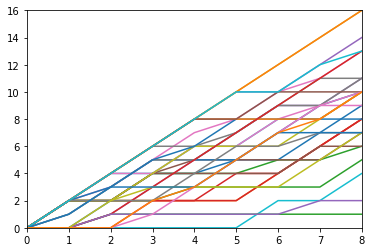

In [135]:
totalpointsbygame.plot(kind = 'line', legend = False, xlim = [0,8], ylim = [0,16])

Next I need to make the transformation to look at points above average.  I'll need the average of the league to do that.

In [137]:
np.mean(totalpointsbygame, axis = 1)

0     0.00000
1     1.28125
2     2.34375
3     3.65625
4     4.65625
       ...   
78        NaN
79        NaN
80        NaN
81        NaN
82        NaN
Length: 83, dtype: float64

Now I'll convert the entries to be how much above or below this teams are at any point in the season.

In [142]:
def comparetoaverage(score,average):
  return score - average

totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1)))

,tampabaylightning,vegasgoldenknights,anaheimducks,coloradoavalanche,edmontonoilers,torontomapleleafs,washingtoncapitals,buffalosabres,carolinahurricanes,columbusbluejackets,...,arizonacoyotes,calgaryflames,chicagoblackhawks,minnesotawild,winnipegjets,dallasstars,seattlekraken,stlouisblues,vancouvercanucks,newyorkislanders
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,-1.28125,0.71875,0.71875,0.71875,0.71875,0.71875,0.71875,0.71875,0.71875,0.71875,...,-1.28125,-1.28125,-1.28125,0.71875,-1.28125,0.71875,-1.28125,0.71875,-0.28125,-1.28125
2,-0.34375,-0.34375,-0.34375,-0.34375,1.65625,-0.34375,0.65625,1.65625,1.65625,1.65625,...,-1.34375,-1.34375,-1.34375,1.65625,-2.34375,-0.34375,-0.34375,1.65625,0.65625,-2.34375
3,0.34375,-1.65625,0.34375,-1.65625,2.34375,0.34375,1.34375,2.34375,2.34375,0.34375,...,-2.65625,-0.65625,-2.65625,2.34375,-2.65625,-1.65625,-0.65625,2.34375,-0.65625,-1.65625
4,-0.65625,-2.65625,-0.65625,-2.65625,3.34375,0.34375,2.34375,1.34375,3.34375,1.34375,...,-3.65625,0.34375,-3.65625,3.34375,-1.65625,-0.65625,-1.65625,3.34375,-1.65625,-1.65625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


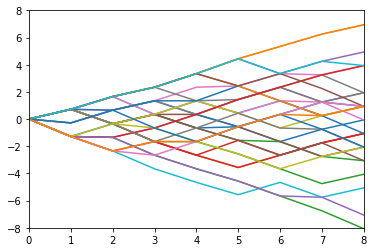

In [143]:
totalpointsbygame.apply(lambda x: comparetoaverage(x,np.mean(totalpointsbygame, axis = 1))).plot(kind = 'line', legend = False, xlim = [0,8], ylim = [-8,8])